**Model Training**
--

**Import Data and Required Packages**

**Importing Pandas, Numpy, Matplotlib, Seaborn and other Libraries**

In [59]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
import warnings

**Import the CSV Data as Pandas DataFrame**

In [2]:
df = pd.read_csv('data/Student_Performance.csv')

**5. Data Pre-Processing**
--

In [3]:
df.isna().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

**There are no missing values in the data set**

**5.1 Removing duplicates**
--

In [4]:
df.duplicated().sum()

np.int64(127)

In [5]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [6]:
df.info

<bound method DataFrame.info of       Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0                 7               99                        Yes            9   
1                 4               82                         No            4   
2                 8               51                        Yes            7   
3                 5               52                        Yes            5   
4                 7               75                         No            8   
...             ...              ...                        ...          ...   
9995              1               49                        Yes            4   
9996              7               64                        Yes            8   
9997              6               83                        Yes            8   
9998              9               97                        Yes            7   
9999              7               74                         No            8   

      S

**5.2 Splitting data into training and test sets**
--

**5.2.1 Corelation matrix**

In [7]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix["Performance Index"].sort_values(ascending=False)

Performance Index                   1.000000
Previous Scores                     0.915135
Hours Studied                       0.375332
Sleep Hours                         0.050352
Sample Question Papers Practiced    0.043436
Name: Performance Index, dtype: float64

**Insights:**
- The attribute that has the greatest impact on the performance index is “Previous results”, while less significant attributes are “Examples of exam tasks that have been completed” and “Hours of sleep”.

**5.2.2 To distribute the full dataset evenly across the two datasets, it is important to split the data into categories based on "Previous Scores"**

In [8]:
df["Previous Scores"].max()

np.int64(99)

<Axes: >

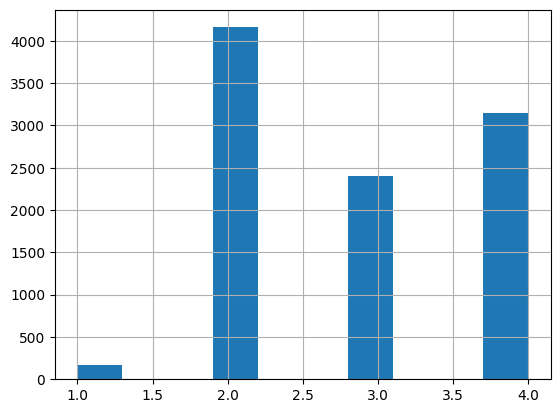

In [9]:
df["income_cat"] = pd.cut(df["Previous Scores"], bins=[0., 40., 65., 80., 100.], labels=[1,2,3,4])
df["income_cat"].hist()

**5.2.3 Performing stratified shuffle split based on Previous Results**

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

**Proportions of categories in test set**

In [11]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
2    0.421266
4    0.318481
3    0.243038
1    0.017215
Name: count, dtype: float64

**Deleting attribute "income_cat"**

In [12]:
strat_train_set = strat_train_set.drop("income_cat", axis=1)
strat_test_set = strat_test_set.drop("income_cat", axis=1)

**5.3 Preparing X and Y variables**
--

In [13]:
df = strat_train_set.drop("Performance Index", axis=1)
df_labels = strat_train_set["Performance Index"].copy()

In [31]:
df.head(5)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
6889,8,87,No,5,3
9588,6,81,Yes,5,2
2321,7,48,No,9,1
4898,6,88,No,7,5
2226,6,73,No,7,5


In [32]:
df_labels.head(5)

6889    79.0
9588    67.0
2321    40.0
4898    76.0
2226    59.0
Name: Performance Index, dtype: float64

**5.4 Creating transformer and feature scaling**
--

**Splitting data into categorical and numerical data**

In [25]:
df_num = df.drop("Extracurricular Activities", axis=1)
df_num.head(5)

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced
6889,8,87,5,3
9588,6,81,5,2
2321,7,48,9,1
4898,6,88,7,5
2226,6,73,7,5


In [14]:
df_cat = df[["Extracurricular Activities"]]
df_cat.head(5)

,Extracurricular Activities
6889,No
9588,Yes
2321,No
4898,No
2226,No


**Adding columns for "Rest to Study Ratio" and "Effort on Top of Knowledge"**

In [33]:
hours_studied, previous_scores, sleep_hours = 0, 1, 3
class CombinedAttributesAdder(BaseEstimator, TransformerMixin) :
    def __init__(self, add_rest_to_study = True):
        self.add_rest_to_study = add_rest_to_study
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if hasattr(X, "iloc"):
            X=X.values
        effort = X[:, previous_scores] * X[:, hours_studied]
        if self.add_rest_to_study:
            rest_to_study = X[:, sleep_hours] / X[:, hours_studied]
            return np.c_[X, effort, rest_to_study]
        else:
            return np.c_[X, effort]

**Feature scaling**

In [34]:
num_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

**Final preparation, using ColumnTransformer and OneHotEncoder for text attributes**

In [35]:
num_attribs = list(df_num)
cat_attribs = ["Extracurricular Activities"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
df_prepared = full_pipeline.fit_transform(df)

**6. Model Training**
--

**6.1 Create an Evaluate Function to give all metrics after model Training**
--

In [40]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [88]:
X_test = strat_test_set.drop("Performance Index", axis=1)
y_test = strat_test_set["Performance Index"].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [89]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Poisson Regressor": PoissonRegressor(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]
mae_list = []
rmse_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(df_prepared, df_labels) # Train model

    # Make predictions
    y_train_pred = model.predict(df_prepared)
    y_test_pred = model.predict(X_test_prepared)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(df_labels, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    r2_list.append(model_test_r2)
    mae_list.append(model_test_mae)
    rmse_list.append(model_test_rmse)
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print(" - First 5 predictions:", y_train_pred[:5])
    print(" - Real first 5 labels:", list(df_labels.iloc[:5]))

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print(" - First 5 predictions:", y_test_pred[:5])
    print(" - Real first 5 labels:", list(y_test.iloc[:5]))
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 2.0347
- Mean Absolute Error: 1.6168
- R2 Score: 0.9887
 - First 5 predictions: [80.33938006 68.95285767 39.22614333 76.96672886 61.6810563 ]
 - Real first 5 labels: [79.0, 67.0, 40.0, 76.0, 59.0]
Model performance for Test set
- Root Mean Squared Error: 2.0786
- Mean Absolute Error: 1.6487
- R2 Score: 0.9884
 - First 5 predictions: [84.06360069 59.92676783 74.41961668 69.47257376 66.63096018]
 - Real first 5 labels: [87.0, 59.0, 70.0, 68.0, 69.0]


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.4888
- Mean Absolute Error: 0.1341
- R2 Score: 0.9994
 - First 5 predictions: [81. 67. 40. 76. 59.]
 - Real first 5 labels: [79.0, 67.0, 40.0, 76.0, 59.0]
Model performance for Test set
- Root Mean Squared Error: 3.1060
- Mean Absolute Error: 2.4741
- R2 Score: 0.9742
 - First 5 predictions: [85. 65. 72. 72. 63.]
 - Real first 5 labels: [87.0, 59.0, 70.0, 68.0, 69.0]


Random Forest Re

**Results**

In [90]:
pd.DataFrame(list(zip(model_list, r2_list, mae_list, rmse_list)), 
columns=['Model Name', 'R2_Score', 'Mae_Score', 'RMSE_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score,Mae_Score,RMSE_Score
0,Linear Regression,0.988440,1.648735,2.078578
5,Ridge,0.988440,1.648776,2.078610
2,Random Forest Regressor,0.984810,1.902349,2.382706
7,AdaBoost Regressor,0.979469,2.204722,2.770144
6,K-Neighbors Regressor,0.975420,2.412253,3.030983
4,Lasso,0.974957,2.405548,3.059411
1,Decision Tree,0.974188,2.474093,3.105999
3,Poisson Regressor,0.963092,2.971244,3.714108


**7. Linear Regression**
--


In [97]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(df_prepared, df_labels)

y_pred = lin_model.predict(X_test_prepared)

model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_test, y_pred)
print("Mae Score:", model_train_mae)
print("RMSE Score:",model_train_rmse)
print("Accuracy of the model is %.2f" %(model_train_r2*100))

Mae Score: 1.6487345777870963
RMSE Score: 2.078577872786996
Accuracy of the model is 98.84


<Axes: xlabel='Performance Index'>

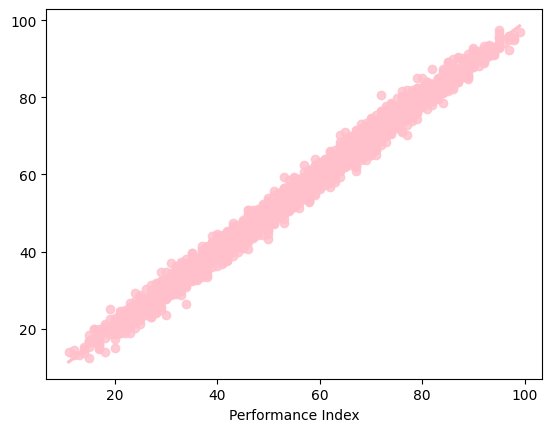

In [98]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='pink')

In [99]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
1617,87.0,84.063601,2.936399
4883,59.0,59.926768,-0.926768
9246,70.0,74.419617,-4.419617
3533,68.0,69.472574,-1.472574
4424,69.0,66.630960,2.369040
...,...,...,...
5007,73.0,75.459174,-2.459174
9256,47.0,47.179990,-0.179990
616,46.0,45.124388,0.875612
6180,79.0,82.512603,-3.512603
